In [151]:
import cv2
from skimage import io
from skimage import img_as_float
from  matplotlib import pyplot as plt
import numpy as np

In [152]:
my_image=io.imread('images/original_images/7.png')

In [153]:
print(type(my_image)) # image is a numpy array
print(my_image.dtype) # image is of dtype
print(my_image.shape) # image is of shape

<class 'numpy.ndarray'>
uint8
(1059, 1024, 3)


In [154]:
from simple_multi_unet_model import multi_unet_model #Uses softmax 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [155]:
# Multiclass Semantic Segmentation on images
SIZE_X=128
SIZE_Y=128
n_classes=4
train_images=[]

In [156]:
for directory_path in glob.glob("images/original_images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [157]:
train_images[0].shape

(128, 128)

In [158]:
train_images[0].dtype

dtype('uint8')

In [159]:
len(train_images)

246

In [160]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [161]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("images/masked_images/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [162]:
train_masks[0].shape

(128, 128)

In [163]:
train_masks[0].dtype

dtype('uint8')

In [164]:
len(train_masks)

246

In [165]:
train_masks.shape

(246, 128, 128)

In [166]:
np.unique(train_masks)

array([  0,  38,  75, 113], dtype=uint8)

In [167]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/home/ankit/Desktop/ml/Tensorflow_ENV/tfenv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [168]:
n, h, w = train_masks.shape

In [169]:
n

246

In [170]:
h

128

In [171]:
w

128

In [172]:
train_masks_reshaped.shape #flatten the image array i.e. n*h*w

(4030464, 1)

In [173]:
train_masks_reshaped_encoded.shape

(4030464,)

In [174]:
train_masks_reshaped_encoded

array([0, 0, 0, ..., 0, 0, 0])

In [175]:
train_masks_encoded_original_shape.shape

(246, 128, 128)

In [176]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

In [177]:
train_images.shape

(246, 128, 128, 1)

In [178]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [179]:
train_masks_input.shape

(246, 128, 128, 1)

In [180]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.1, random_state = 0)

#Further split training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3]


In [181]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [182]:
y_train_cat.shape

(176, 128, 128, 4)

In [183]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [184]:
y_test_cat.shape

(25, 128, 128, 4)

In [185]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_masks_reshaped_encoded),y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [0.45590823 0.66007216 8.08700049 5.9546846 ]


In [186]:
class_weights = {i : class_weights[i] for i in range(4)}

In [187]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

 conv2d_53 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_25[0][0]']             
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 128, 128, 16  2064       ['conv2d_53[0][0]']              
 nspose)                        )                                                                 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_11[0][0]',    
                                )                                 'conv2d_39[0][0]']              
                                                                                                  
 conv2d_54 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_11[0][0]']         
                                )                                                                 
          

In [188]:
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #sample_weight=class_weights,
                    shuffle=False)
                    

Epoch 1/50
11/11 [==============================] - 15s 766ms/step - loss: 1.3460 - accuracy: 0.3717 - val_loss: 1.2041 - val_accuracy: 0.3690
Epoch 2/50
11/11 [==============================] - 6s 543ms/step - loss: 1.0585 - accuracy: 0.4837 - val_loss: 0.9605 - val_accuracy: 0.5725
Epoch 3/50
11/11 [==============================] - 6s 545ms/step - loss: 0.9688 - accuracy: 0.5412 - val_loss: 0.9477 - val_accuracy: 0.5726
Epoch 4/50
11/11 [==============================] - 6s 543ms/step - loss: 0.9540 - accuracy: 0.5392 - val_loss: 0.9349 - val_accuracy: 0.5725
Epoch 5/50
11/11 [==============================] - 6s 546ms/step - loss: 0.9361 - accuracy: 0.5585 - val_loss: 0.8988 - val_accuracy: 0.5755
Epoch 6/50
11/11 [==============================] - 6s 543ms/step - loss: 0.8088 - accuracy: 0.6888 - val_loss: 0.9442 - val_accuracy: 0.6746
Epoch 7/50
11/11 [==============================] - 6s 545ms/step - loss: 0.6606 - accuracy: 0.7830 - val_loss: 0.8151 - val_accuracy: 0.7119
Epoch

In [189]:
#model.save('test.hdf5')
model.save('cell_50_epochs_catXentropy_acc_with_weights.hdf5')

In [190]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 3s 3s/step - loss: 0.5093 - accuracy: 0.8566
Accuracy is =  85.6555163860321 %


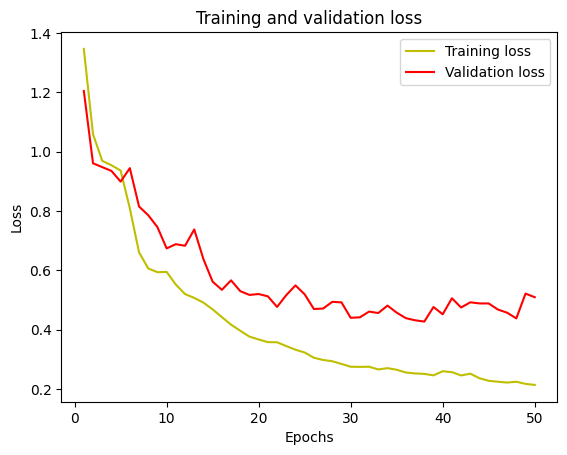

In [191]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

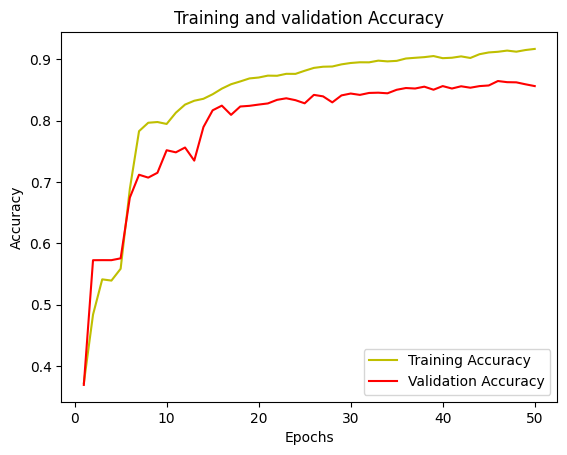

In [192]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [193]:
##################################
#model = get_model()
#model.load_weights('sandstone_50_epochs_catXentropy_acc.hdf5')  
model.load_weights('cell_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


1/1 [==============================] - 0s 284ms/step


In [194]:
##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.47220066


In [195]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[2.27159e+05 7.44100e+03 0.00000e+00 1.00000e+00]
 [2.34900e+04 1.16259e+05 1.15200e+03 4.61100e+03]
 [2.41200e+03 6.42900e+03 8.31000e+02 3.23300e+03]
 [1.60500e+03 8.37800e+03 3.00000e+00 6.59600e+03]]
IoU for class1 is:  0.86666185
IoU for class2 is:  0.6930079
IoU for class3 is:  0.05910384
IoU for class4 is:  0.27002907


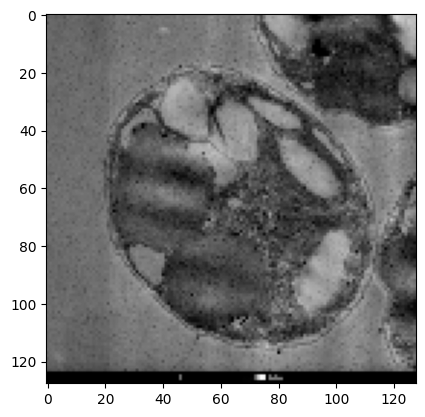

In [196]:
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.show()

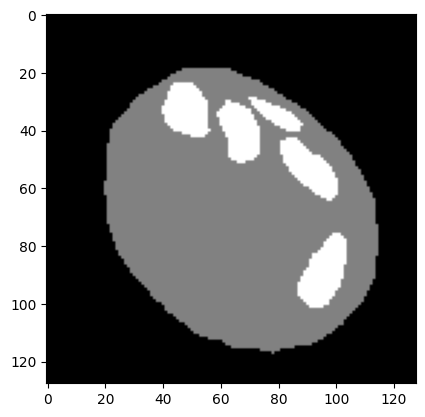

In [197]:
plt.imshow(train_masks[0], cmap='gray')
plt.show()

In [198]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 1s 1s/step


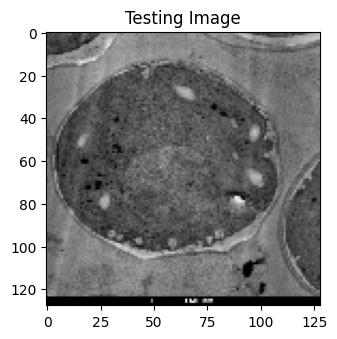

In [199]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

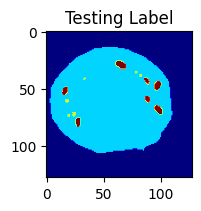

In [200]:
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

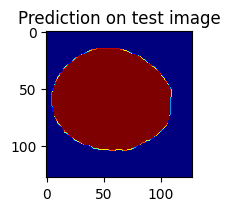

In [201]:
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

## For Large Images

In [ ]:
#Predict on large image

#Apply a trained model on large image

from patchify import patchify, unpatchify

large_image = cv2.imread('original_images/2.png', 0)

In [ ]:
large_image.shape

In [ ]:
# remember define patch size so that it divides the image shape like 353 divides 1059 and 256 divides 1024

In [ ]:
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128,128), step=128)  #Step=256 for 256 patches means no overlap
# 1059/128=8 and 1024/128=8 and so total 8*8=64 images per one long image

In [ ]:
patches.shape

In [ ]:
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')

In [ ]:
plt.show()

In [ ]:
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

In [ ]:
plt.show()

In [ ]:
#####################################################################

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()

In [ ]:
# Above process is for one image. Now, we do for all the images

In [ ]:
from simple_multi_unet_model import multi_unet_model #Uses softmax (From video 208)

from keras.utils import normalize
import os
import glob
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify


n_classes=4 #Number of classes for segmentation
IMG_HEIGHT = 128
IMG_WIDTH  = 128
IMG_CHANNELS = 1

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


model.load_weights('cell_500_epochs_catXentropy_acc_with_weights.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  


segm_images = []
path = "original_images/*.png"
from pathlib import Path
for file in glob.glob(path):
    #print(file)     #just stop here to see all file names printed
    name = Path(file).stem #Get the original file name
    #print(name)
  
    large_image = cv2.imread(file, 0)
    
    patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
    
    predicted_patches = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            #print(i,j)
            
            single_patch = patches[i,j,:,:]
            
            single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
            single_patch_input=np.expand_dims(single_patch_norm, 0)
    
            single_patch_prediction = (model.predict(single_patch_input))
            single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]
    
            predicted_patches.append(single_patch_predicted_img)
    
    predicted_patches = np.array(predicted_patches)
    
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )
    
    reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
    #Here you can save individual images, or save on milti_dim tiff file
    #cv2.imwrite('segmented_images/' + name + '_segmented.tif', reconstructed_image)
    segm_images.append(reconstructed_image)
    print("Finished segmenting image: ", name)
    
    
final_segm_image = np.array(segm_images).astype(np.uint8)   

from tifffile import imsave
imsave('segmented_images/cell.tif', final_segm_image)